In [1]:
import gc 
import numpy as np # linear algebra
from numpy import hstack
from numpy import array
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

from scipy import stats
from scipy.stats import norm, skew #for some statistics

In [2]:
# read saved train data: imputed X by univariate
df = pd.read_csv('/accounts/grad/huz4/Desktop/STAT222/univariate_imputed__full_data.csv')

In [3]:
df.columns

Index(['Unnamed: 0', 'airconditioningtypeid', 'bathroomcnt', 'bedroomcnt',
       'buildingqualitytypeid', 'decktypeid', 'calculatedfinishedsquarefeet',
       'fips', 'fireplacecnt', 'garagecarcnt', 'garagetotalsqft',
       'heatingorsystemtypeid', 'lotsizesquarefeet', 'poolcnt', 'poolsizesum',
       'pooltypeid2', 'propertylandusetypeid', 'regionidcounty', 'unitcnt',
       'yardbuildingsqft17', 'yearbuilt', 'taxamount', 'taxdelinquencyflag',
       'dist_to_dtla', 'dist_to_ocean', 'price'],
      dtype='object')

In [4]:
df.drop(['Unnamed: 0','taxamount','taxdelinquencyflag'], axis = 1, inplace = True)

In [5]:
df.columns

Index(['airconditioningtypeid', 'bathroomcnt', 'bedroomcnt',
       'buildingqualitytypeid', 'decktypeid', 'calculatedfinishedsquarefeet',
       'fips', 'fireplacecnt', 'garagecarcnt', 'garagetotalsqft',
       'heatingorsystemtypeid', 'lotsizesquarefeet', 'poolcnt', 'poolsizesum',
       'pooltypeid2', 'propertylandusetypeid', 'regionidcounty', 'unitcnt',
       'yardbuildingsqft17', 'yearbuilt', 'dist_to_dtla', 'dist_to_ocean',
       'price'],
      dtype='object')

In [6]:
df.shape

(2949618, 23)

In [7]:
float_var = ["bathroomcnt", 
                   "bedroomcnt", 
                   "buildingqualitytypeid", 
                   "calculatedfinishedsquarefeet",
                  "fireplacecnt", 
                   "garagecarcnt", 
                   "garagetotalsqft",
                   "dist_to_dtla", 
                   "dist_to_ocean", 
                   "lotsizesquarefeet", 
                   "poolcnt",
                  "poolsizesum", 
                   "unitcnt", 
                   "yardbuildingsqft17",
                    "price"]

df_no_out = df[(np.abs(stats.zscore(df[float_var])) < 3).all(axis=1)]

One of the most important steps in our data preprocessing is detecting and treating the outliers as they can negatively affect the statistical analysis and the training process of a machine learning algorithm resulting in lower accuracy. In this project, we will detect outliers using the Z-scores method, and define a threshold value of 3 and mark the datapoints whose absolute value of Z-score is greater than the threshold as outliers. Since we have imputed missing with mode/median in the EDA part, if we find any outliers in those columns, we will follow the same strategy. Otherwise, we will delete them directly

In [ ]:
# inputation with median columns
median_df = df[["buildingqualitytypeid", "lotsizesquarefeet", "bathroomcnt", "bedroomcnt", "calculatedfinishedsquarefeet",
                      "structuretaxvaluedollarcnt", "landtaxvaluedollarcnt"]]

# inputation with mode columns
mode_df = df[["airconditioningtypeid", "heatingorsystemtypeid", "unitcnt", "fips", 
                    "propertylandusetypeid", "regionidcounty", "yearbuilt"]]

remove outiler with z score greater than 3( only for continuous featrues)

In [43]:
# replace outliers with median or mode
def replace_outliers(df):
    df = df.copy() # make a copy of the orginal Dataframe
    for col1 in median_df.columns:
        col_median = df[col1].median()
        col_std = df[col1].std()
        df[col1] = np.where(np.abs(stats.zscore(df[col1]))>3, col_median,df[col1])
    for col2 in mode_df.columns:
        col_mode = df[col2].mode()
        col_std = df[col2].std()
        df[col2] = np.where(np.abs(stats.zscore(df[col2]))>3, col_mode, df[col2])
    return df

In [ ]:
# replace outliers
df = replace_outliers(df)

In [44]:
# delete all other outliers in the following columns
continuous_df = df[['fireplacecnt', 'garagecarcnt', 'garagetotalsqft',
                     'poolcnt', 'poolsizesum', 'unitcnt', 'yardbuildingsqft17',
                     'dist_to_dtla', 'dist_to_ocean']]
def find_outliers(col):
    zscore_col = np.abs(stats.zscore(col))
    keep_index = np.where(zscore_col > 3, False, True)
    return pd.Series(keep_index, index=col.index)

continuous_df_outlier_flag = continuous_df.apply(find_outliers, axis=0)

# if property has no outliers in any of the columns, keep it
no_outlier_index = np.where(continuous_df_outlier_flag.apply(all, axis=1) == True)
df = df.iloc[no_outlier_index]

In [8]:
## seperate the single house, emptyland and appartment for EDA plots
condominium = df[(df['propertylandusetypeid'] == 266)]

# multi-unit-home includes duplex, triplex, quadruplex
multi_unit_home = df[(df['propertylandusetypeid'] == 246) |
                    (df['propertylandusetypeid'] == 247) |
                    (df['propertylandusetypeid'] == 248)]
                       
single_family = df[df['propertylandusetypeid'] == 261]

# Planned Unit Development (townhouse)
townhouse = df[df['propertylandusetypeid'] == 269]

mobile_home = df[df['propertylandusetypeid'] == 263]

In [9]:
# do a 80,20 split on each data, set a seed
import random
random.seed(222)
from sklearn.model_selection import train_test_split

train_con, test_con = train_test_split(condominium, test_size=0.2)
train_mul, test_mul = train_test_split(multi_unit_home, test_size=0.2)
train_sin, test_sin = train_test_split(single_family, test_size=0.2)
train_town, test_town = train_test_split(townhouse, test_size=0.2)
train_mob, test_mob = train_test_split(mobile_home, test_size=0.2)

In [10]:
#condo
X_train_con = train_con.drop(['price'], axis =1)
Y_train_con = train_con['price']
X_test_con = test_con.drop(['price'], axis =1)
Y_test_con = test_con['price']

#multi_unit
X_train_mul = train_mul.drop(['price'], axis =1)
Y_train_mul = train_mul['price']
X_test_mul = test_mul.drop(['price'], axis =1)
Y_test_mul = test_mul['price']

#single_family
X_train_sin = train_sin.drop(['price'], axis =1)
Y_train_sin = train_sin['price']
X_test_sin = test_sin.drop(['price'], axis =1)
Y_test_sin = test_sin['price']

#townhouse
X_train_town = train_town.drop(['price'], axis =1)
Y_train_town = train_town['price']
X_test_town = test_town.drop(['price'], axis =1)
Y_test_town = test_town['price']

#mobile_home
X_train_mob = train_mob.drop(['price'], axis =1)
Y_train_mob = train_mob['price']
X_test_mob = test_mob.drop(['price'], axis =1)
Y_test_mob = test_mob['price']

In [11]:
print(X_train_con.shape)
print(Y_train_con.shape)
print(X_test_con.shape)
print(Y_test_con.shape)

(386736, 22)
(386736,)
(96684, 22)
(96684,)


In [12]:
X_train_con.columns

Index(['airconditioningtypeid', 'bathroomcnt', 'bedroomcnt',
       'buildingqualitytypeid', 'decktypeid', 'calculatedfinishedsquarefeet',
       'fips', 'fireplacecnt', 'garagecarcnt', 'garagetotalsqft',
       'heatingorsystemtypeid', 'lotsizesquarefeet', 'poolcnt', 'poolsizesum',
       'pooltypeid2', 'propertylandusetypeid', 'regionidcounty', 'unitcnt',
       'yardbuildingsqft17', 'yearbuilt', 'dist_to_dtla', 'dist_to_ocean'],
      dtype='object')

In [32]:
X_test_con.columns

Index(['airconditioningtypeid', 'bathroomcnt', 'bedroomcnt',
       'buildingqualitytypeid', 'decktypeid', 'calculatedfinishedsquarefeet',
       'fips', 'fireplacecnt', 'garagecarcnt', 'garagetotalsqft',
       'heatingorsystemtypeid', 'lotsizesquarefeet', 'poolcnt', 'poolsizesum',
       'pooltypeid2', 'propertylandusetypeid', 'regionidcounty', 'unitcnt',
       'yardbuildingsqft17', 'yearbuilt', 'dist_to_dtla', 'dist_to_ocean'],
      dtype='object')

In [13]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
def get_eval_metrics(models, X, y_true): 
    """
    Calculates MAE (Mean Absoulate Error) and RMSE (Root Mean Squared Error) on the data set for input models. 
    `models`: list of fit models 
    """
    for model in models: 
        y_pred= model.predict(X)
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        mae = mean_absolute_error(y_true, y_pred)
        print(f"Model: {model}")
        print(f"MAE: {mae}, RMSE: {rmse}")

# Test usage of RMSE function
# get_eval_metrics([lin_reg, ridge_reg, lasso_reg], X_prepared_val, y_val)

#calculate average log error 
import math
from statistics import mean
def get_avg_log_error(model, x, y_true):
    """
    Calculate average log error on the data set for imput models
    log error = log(true price) - log(prediction)
    """
    y_pred= model.predict(x)
    avg_log_error = mean( np.log(y_true) - np.log(y_pred))
    print(f"Model: {model}")
    print(f"log_error: {avg_log_error}")

# condominium

## Random forest

In [65]:
best_params ={'max_depth': 50,
              'n_estimators': 400,
            'max_features': 0.6,
            'min_samples_leaf': 16,
             'n_jobs':-1}
ran_forest_con = RandomForestRegressor(**best_params)
ran_forest_con.fit(X_train_con, Y_train_con)

RandomForestRegressor(max_depth=50, max_features=0.6, min_samples_leaf=16,
                      n_estimators=400, n_jobs=-1)

In [68]:
get_eval_metrics([ran_forest_con], X_test_con, Y_test_con)

Model: RandomForestRegressor(max_depth=50, max_features=0.6, min_samples_leaf=16,
                      n_estimators=400, n_jobs=-1)
MAE: 94904.9706800773, RMSE: 190289.15422734304


In [69]:
get_avg_log_error(ran_forest_con, X_test_con, Y_test_con)

Model: RandomForestRegressor(max_depth=50, max_features=0.6, min_samples_leaf=16,
                      n_estimators=400, n_jobs=-1)
log_error: -0.07570456309515025


## Gradient Boosting(XGBoost)

In [285]:
X_test_con.shape

(93276, 22)

In [286]:
train_con.shape

(373104, 23)

In [14]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer

In [15]:
# do a 80,20 split on data for validation, set a seed
import random
random.seed(222)
from sklearn.model_selection import train_test_split

#set validation set for early stopping
train_con, valid_con = train_test_split(train_con, test_size=0.2)

X_train_con = train_con.drop(['price'], axis =1)
Y_train_con = train_con['price']
X_valid_con = valid_con.drop(['price'], axis =1)
Y_valid_con = valid_con['price']

In [16]:
d_train = xgb.DMatrix(X_train_con, label=Y_train_con, enable_categorical=True)
d_valid = xgb.DMatrix(X_valid_con, label=Y_valid_con, enable_categorical=True)


print('Training ...')

params = {}
params['eta'] = 0.3
params['objective'] = 'reg:linear'
params['eval_metric'] = 'mae'
params['max_depth'] = 4
params['silent'] = 1

watchlist = [(d_train, 'train'), (d_valid, 'valid')]
clf = xgb.train(params, d_train, 10000, watchlist, early_stopping_rounds=10, verbose_eval=50)



d_test = xgb.DMatrix(X_test_con, enable_categorical=True)


print('Predicting on test ...')

p_test_con = clf.predict(d_test)

import math
logerror = np.log(p_test_con) - np.log(Y_test_con)
print('mean log error', np.mean(logerror))
print('Done!')

Training ...
[20:15:23] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[20:15:23] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



/accounts/grad/huz4/.local/lib/python3.11/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-mae:258174.58190	valid-mae:258269.50014
[50]	train-mae:105350.06108	valid-mae:107007.64799
[100]	train-mae:101922.86473	valid-mae:104348.63790
[150]	train-mae:99849.03891	valid-mae:102827.16678
[200]	train-mae:98450.32233	valid-mae:101829.15571
[250]	train-mae:97071.21039	valid-mae:100903.70325
[300]	train-mae:96179.63796	valid-mae:100393.27725
[310]	train-mae:96093.69644	valid-mae:100379.12695
Predicting on test ...
mean log error 0.0783548214264479
Done!


/tmp/ipykernel_883612/1414060588.py:27: RuntimeWarning: invalid value encountered in log
  logerror = np.log(p_test_con) - np.log(Y_test_con)


In [20]:
get_eval_metrics([clf], d_test, Y_test_con)

Model: <xgboost.core.Booster object at 0x7f73aca82d90>
MAE: 100491.97787057297, RMSE: 193060.81682497496


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

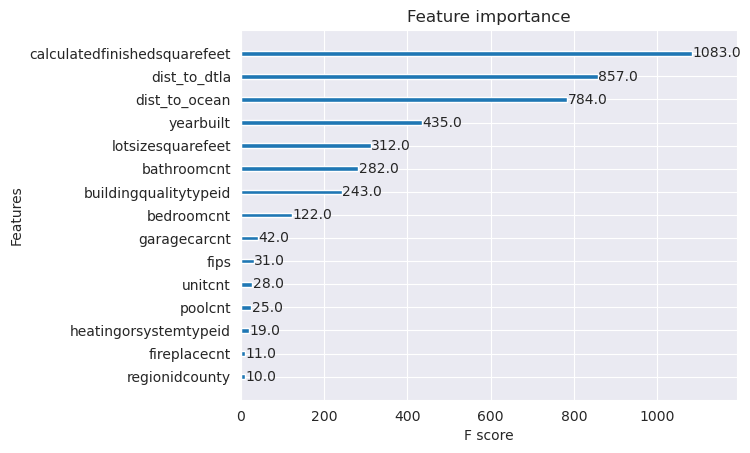

In [17]:
from xgboost import plot_importance
plot_importance(clf, max_num_features = 15)

In [21]:
import lightgbm as lgb
d_train = lgb.Dataset(X_train_con, label=Y_train_con)
d_valid = lgb.Dataset(X_valid_con, label=Y_valid_con)

params = {}
params['learning_rate'] = 0.03
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'mae'
params['sub_feature'] = 0.5
params['num_leaves'] = 60
params['min_data'] = 500
params['min_hessian'] = 1

watchlist = [d_valid]
clf = lgb.train(params, d_train, 500, watchlist,early_stopping_rounds=10, verbose_eval=50)

print('Done!')

/accounts/grad/huz4/.local/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/accounts/grad/huz4/.local/lib/python3.11/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026698 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1374
[LightGBM] [Info] Number of data points in the train set: 309388, number of used features: 17
[LightGBM] [Info] Start training from score 366311.708806
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	valid_0's l1: 118661
[100]	valid_0's l1: 109202
[150]	valid_0's l1: 106201
[200]	valid_0's l1: 104817
[250]	valid_0's l1: 103933
[300]	valid_0's l1: 103320
[350]	valid_0's l1: 102785
[400]	valid_0's l1: 102280
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[450]	valid_0's l1: 101905
[500]	valid_0's l1: 101550
Did not meet early stopping. Best iteration is:
[500]	valid_0's l1: 101550
Done!


In [22]:
# testing set error
get_eval_metrics([clf], X_test_con, Y_test_con)

Model: <lightgbm.basic.Booster object at 0x7f73643349d0>
MAE: 101824.21691938603, RMSE: 204108.76732939942


In [23]:
# testing log error
def replace_negative_with_one(lst):
    return [max(1, num) for num in lst]

p_test = clf.predict(X_test_con)
p_test = replace_negative_with_one(p_test)
import math
logerror = np.log(p_test) - np.log(Y_test_con)
print('mean log error', np.mean(logerror))

mean log error 0.08362266303693461


## Gradient Boosting(AdaBoost)

In [38]:
#Ada boosting regression model
from sklearn.datasets import make_regression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [ ]:
ada = AdaBoostRegressor()
ada.fit(X_train_con, Y_train_con)
# training MAE and RMSE
get_eval_metrics([ada], X_train_con, Y_train_con)
# testing MAE and RMSE
get_eval_metrics([ada], X_test_con, Y_test_con)
#average log error
get_avg_log_error(ada, X_test_con, Y_test_con)

## Linear Regression

In [53]:
#linear regression
from sklearn import linear_model

In [54]:
#fitting regression model
regr = linear_model.LinearRegression()
regr.fit(X_train_con, Y_train_con)
print(regr.coef_)

[ 5.48658476e+11 -6.95440184e+03 -5.43734253e+02 -3.50305688e+03
 -2.21257414e+10  2.64127175e+04  7.91342018e+11 -1.32795793e+04
  1.32070557e+04  2.04948711e+08 -4.82941192e+11  1.30795557e+04
 -1.32591248e+02 -1.68968494e+03 -4.19683768e+08 -1.34353254e+08
  6.78248585e+10  3.17290923e+04  2.00805048e+03 -1.17954657e+03
  4.90754123e+05  4.56184806e+05  3.81714966e+02  1.71606885e+03
  8.40106069e+11 -4.64647868e+12 -5.19513716e+12 -5.74379573e+12
 -2.57210892e+11 -1.35452783e+12 -3.54916170e+12 -5.74642851e+12
 -1.39995781e+12 -9.17016608e+11 -4.34075408e+11  4.88657330e+10
 -2.46386838e+06  2.46357172e+12 -5.26348733e+12  3.42945409e+12
  3.91239530e+12  5.36121888e+12 -3.33172257e+12 -2.84878135e+12
 -2.70109715e+13  2.58353254e+13 -2.10216997e+13  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000

In [34]:
# training MAE and RMSE
get_eval_metrics([regr], X_train_con, Y_train_con)
# testing MAE and RMSE
get_eval_metrics([regr], X_test_con, Y_test_con)
#average log error
get_avg_log error(ada, X_test_con, Y_test_con)

Model: LinearRegression()
MAE: 32000.71557357754, RMSE: 54660.355543825484
Model: LinearRegression()
MAE: 31872.86856055413, RMSE: 54637.19570343414


# multi_unit_home

## Random forest

In [71]:
best_params ={'max_depth': 50,
              'n_estimators': 400,
            'max_features': 0.6,
            'min_samples_leaf': 16,
             'n_jobs':-1}
ran_forest_mul = RandomForestRegressor(**best_params)
ran_forest_mul.fit(X_train_mul, Y_train_mul)

RandomForestRegressor(max_depth=50, max_features=0.6, min_samples_leaf=16,
                      n_estimators=400, n_jobs=-1)

In [73]:
get_eval_metrics([ran_forest_mul], X_test_mul, Y_test_mul)

Model: RandomForestRegressor(max_depth=50, max_features=0.6, min_samples_leaf=16,
                      n_estimators=400, n_jobs=-1)
MAE: 190536.51483493406, RMSE: 301986.5334762679


In [74]:
get_avg_log_error(ran_forest_mul, X_test_mul, Y_test_mul)

Model: RandomForestRegressor(max_depth=50, max_features=0.6, min_samples_leaf=16,
                      n_estimators=400, n_jobs=-1)
log_error: -0.2290743445972561


## Gradient Boosting(XGBoost)

In [24]:
train_mul, valid_mul = train_test_split(train_mul, test_size=0.2)
#set validation set for early stopping

X_train_mul = train_mul.drop(['price'], axis =1)
Y_train_mul = train_mul['price']
X_valid_mul = valid_mul.drop(['price'], axis =1)
Y_valid_mul = valid_mul['price']


In [25]:
X_test_mul.shape

(38976, 22)

In [31]:
d_train_mul = xgb.DMatrix(X_train_mul, label=Y_train_mul, enable_categorical=True)
d_valid_mul = xgb.DMatrix(X_valid_mul, label=Y_valid_mul, enable_categorical=True)


print('Training ...')

params = {}
params['eta'] = 0.03
params['objective'] = 'reg:linear'
params['eval_metric'] = 'mae'
params['max_depth'] = 4
params['silent'] = 1

watchlist = [(d_train_mul, 'train'), (d_valid_mul, 'valid')]
clf_mul = xgb.train(params, d_train_mul, 10000, watchlist, early_stopping_rounds=10, verbose_eval=50)



d_test_mul = xgb.DMatrix(X_test_mul, enable_categorical=True)


print('Predicting on test ...')

p_test_mul = clf_mul.predict(d_test_mul)
p_test_mul = replace_negative_with_one(p_test_mul)
import math
logerror = np.log(p_test_mul) - np.log(Y_test_mul)
print('mean log error', np.mean(logerror))
print('Done!')

Training ...
[20:21:46] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[20:21:46] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



/accounts/grad/huz4/.local/lib/python3.11/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-mae:384974.94016	valid-mae:384068.13954
[50]	train-mae:195745.26468	valid-mae:195151.88857
[84]	train-mae:191737.68275	valid-mae:191721.82397
Predicting on test ...
mean log error 0.17509414318737151
Done!


In [27]:
# testing set error
get_eval_metrics([clf_mul], d_test_mul, Y_test_mul)

Model: <xgboost.core.Booster object at 0x7f734fd7b710>
MAE: 192919.7009461752, RMSE: 314309.54500593577


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

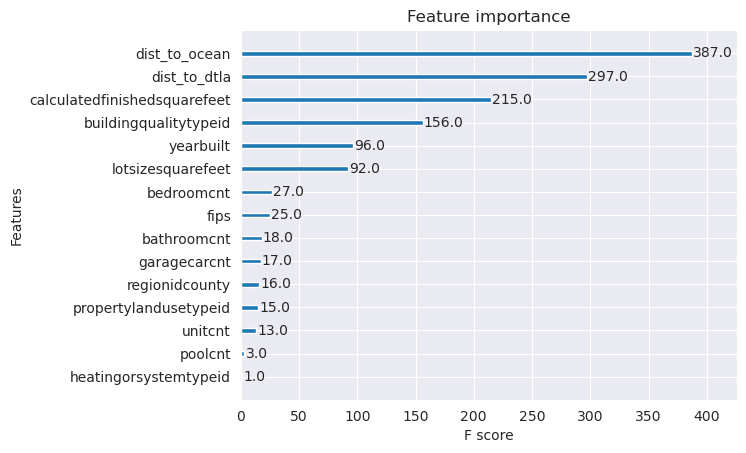

In [47]:
from xgboost import plot_importance
plot_importance(clf_mul, max_num_features = 15)

In [28]:
d_train = lgb.Dataset(X_train_mul, label=Y_train_mul)
d_valid = lgb.Dataset(X_valid_mul, label=Y_valid_mul)

params = {}
params['learning_rate'] = 0.03
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'mae'
params['sub_feature'] = 0.5
params['num_leaves'] = 60
params['min_data'] = 500
params['min_hessian'] = 1

watchlist = [d_valid]
clf_mul = lgb.train(params, d_train, 500, watchlist,early_stopping_rounds=10, verbose_eval=50)

print('Done!')

/accounts/grad/huz4/.local/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/accounts/grad/huz4/.local/lib/python3.11/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007103 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 124722, number of used features: 17
[LightGBM] [Info] Start training from score 396863.530572
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l1: 195243
[100]	valid_0's l1: 192471
[150]	valid_0's l1: 191873
[200]	valid_0's l1: 191765
Early stopping, best iteration is:
[191]	valid_0's l1: 191756
Done!


In [29]:
# testing set error
get_eval_metrics([clf_mul], X_test_mul, Y_test_mul)

Model: <lightgbm.basic.Booster object at 0x7f734fd64f90>
MAE: 192034.3871152348, RMSE: 306093.760073505


In [30]:
# testing log error

p_test = clf_mul.predict(X_test_mul)
p_test = replace_negative_with_one(p_test)
import math
logerror = np.log(p_test) - np.log(Y_test_mul)
print('mean log error', np.mean(logerror))

mean log error 0.23360800267648665


## Gradient Boosting(AdaBoost)

In [55]:
ada = AdaBoostRegressor()
ada.fit(X_train_mul, Y_train_mul)
# training MAE and RMSE
get_eval_metrics([ada], X_train_mul, Y_train_mul)
# testing MAE and RMSE
get_eval_metrics([ada], X_test_mul, Y_test_mul)
#average log error
get_avg_log error(ada, X_test_con, Y_test_con)

Model: AdaBoostRegressor()
MAE: 127042.02117239841, RMSE: 151822.35542778383
Model: AdaBoostRegressor()
MAE: 126344.89613312043, RMSE: 151576.64718266492


## Linear Regression

In [56]:
#fitting regression model
regr = linear_model.LinearRegression()
regr.fit(X_train_mul, Y_train_mul)
print(regr.coef_)

[ 1.34739108e+13 -1.56418811e+03  3.45114941e+03 -2.27153125e+03
 -4.46203125e+02 -1.08489844e+03 -7.29945312e+02 -6.40771484e+02
 -2.34214258e+03 -2.14843750e-02  1.36277344e+03 -3.28735547e+03
  2.45392969e+03  2.34375000e-02 -1.25474648e+04 -9.47509473e+03
 -2.75712891e+01  5.12990928e+04 -3.53235767e+03 -1.70700928e+02
  4.89556595e+05  4.44763381e+05 -1.94653125e+03 -3.94620117e+03
  8.08434647e+13  2.92968750e-03  0.00000000e+00 -8.08434647e+13
  0.00000000e+00  2.69478216e+13 -2.69478216e+13  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  3.77649782e+03  9.55846717e+02
  0.00000000e+00  0.00000000e+00 -7.58041870e+03  2.88522046e+03
  1.30444749e+00  3.41454163e+01 -1.99372140e+01  3.72148312e+03
  2.07653445e+03 -5.78461152e+03  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000

In [57]:
# training MAE and RMSE
get_eval_metrics([regr], X_train_mul, Y_train_mul)
# testing MAE and RMSE
get_eval_metrics([regr], X_test_mul, Y_test_mul)
#average log error
get_avg_log error(ada, X_test_con, Y_test_con)

Model: LinearRegression()
MAE: 30682.305887101033, RMSE: 58824.13258301638
Model: LinearRegression()
MAE: 31165.94747873954, RMSE: 59078.37137954393


# single_family

## Random forest

In [75]:
best_params ={'max_depth': 50,
              'n_estimators': 400,
            'max_features': 0.6,
            'min_samples_leaf': 16,
             'n_jobs':-1}
ran_forest_sin = RandomForestRegressor(**best_params)
ran_forest_sin.fit(X_train_sin, Y_train_sin)

RandomForestRegressor(max_depth=50, max_features=0.6, min_samples_leaf=16,
                      n_estimators=400, n_jobs=-1)

In [76]:
get_eval_metrics([ran_forest_sin], X_test_sin, Y_test_sin)

Model: RandomForestRegressor(max_depth=50, max_features=0.6, min_samples_leaf=16,
                      n_estimators=400, n_jobs=-1)
MAE: 191745.10908351338, RMSE: 444593.6177041965


In [77]:
get_avg_log_error(ran_forest_sin, X_test_sin, Y_test_sin)

Model: RandomForestRegressor(max_depth=50, max_features=0.6, min_samples_leaf=16,
                      n_estimators=400, n_jobs=-1)
log_error: -0.18797317720978773


## Gradient Boosting(XGBoost)

In [32]:
train_sin, valid_sin = train_test_split(train_sin, test_size=0.2)
#set validation set for early stopping

X_train_sin = train_sin.drop(['price'], axis =1)
Y_train_sin = train_sin['price']
X_valid_sin = valid_sin.drop(['price'], axis =1)
Y_valid_sin = valid_sin['price']

In [33]:
X_train_sin.shape

(1376938, 22)

In [34]:
d_train_sin = xgb.DMatrix(X_train_sin, label=Y_train_sin, enable_categorical= True)
d_valid_sin = xgb.DMatrix(X_valid_sin, label=Y_valid_sin, enable_categorical= True)


print('Training ...')

params = {}
params['eta'] = 0.3
params['objective'] = 'reg:linear'
params['eval_metric'] = 'mae'
params['max_depth'] = 4
params['silent'] = 1

watchlist = [(d_train_sin, 'train'), (d_valid_sin, 'valid')]
clf_sin = xgb.train(params, d_train_sin, 10000, watchlist, early_stopping_rounds=10, verbose_eval=50)



d_test_sin = xgb.DMatrix(X_test_sin, enable_categorical= True)


print('Predicting on test ...')

p_test_sin = clf_sin.predict(d_test_sin)

import math
logerror = np.log(p_test_sin) - np.log(Y_test_sin)
print('mean log error', np.mean(logerror))
print('Done!')

Training ...
[20:23:44] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[20:23:44] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



/accounts/grad/huz4/.local/lib/python3.11/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-mae:333152.30789	valid-mae:333692.13707
[50]	train-mae:200652.76806	valid-mae:202102.03771
[100]	train-mae:197321.39596	valid-mae:199922.14250
[150]	train-mae:195441.61132	valid-mae:198810.18635
[184]	train-mae:194555.47232	valid-mae:198452.35478
Predicting on test ...
mean log error 0.188961890394218
Done!


/tmp/ipykernel_883612/2667676359.py:27: RuntimeWarning: invalid value encountered in log
  logerror = np.log(p_test_sin) - np.log(Y_test_sin)


In [35]:
# testing set error
get_eval_metrics([clf_sin], d_test_sin, Y_test_sin)

Model: <xgboost.core.Booster object at 0x7f73ac123d50>
MAE: 199036.47572283816, RMSE: 455536.0105888341


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

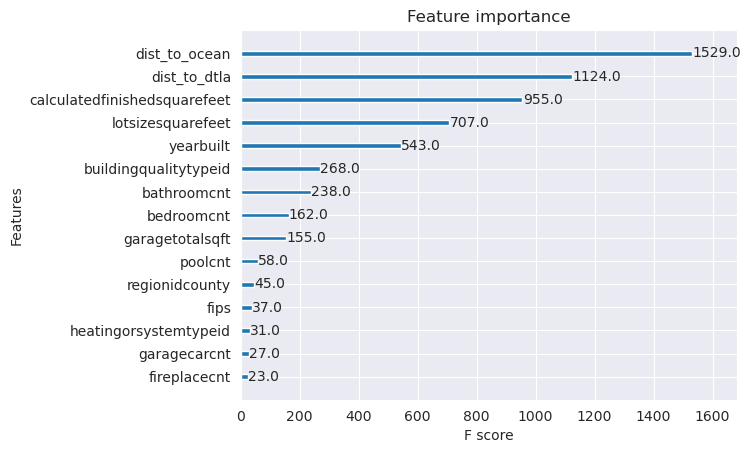

In [53]:
from xgboost import plot_importance
plot_importance(clf_sin, max_num_features = 15)

In [36]:
d_train = lgb.Dataset(X_train_sin, label=Y_train_sin)
d_valid = lgb.Dataset(X_valid_sin, label=Y_valid_sin)

params = {}
params['learning_rate'] = 0.03
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'mae'
params['sub_feature'] = 0.5
params['num_leaves'] = 60
params['min_data'] = 500
params['min_hessian'] = 1

watchlist = [d_valid]
clf_sin = lgb.train(params, d_train, 500, watchlist,early_stopping_rounds=10, verbose_eval=50)

print('Done!')

/accounts/grad/huz4/.local/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/accounts/grad/huz4/.local/lib/python3.11/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.144043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2021
[LightGBM] [Info] Number of data points in the train set: 1376938, number of used features: 21
[LightGBM] [Info] Start training from score 461619.798122
Training until validation scores don't improve for 10 rounds
[50]	valid_0's l1: 212444
[100]	valid_0's l1: 201474
[150]	valid_0's l1: 198335
[200]	valid_0's l1: 197310
[250]	valid_0's l1: 196694
[300]	valid_0's l1: 196274
[350]	valid_0's l1: 195929
[400]	valid_0's l1: 195586
[450]	valid_0's l1: 195310
[500]	valid_0's l1: 195040
Did not meet early stopping. Best iteration is:
[499]	valid_0's l1: 195040
Done!


In [37]:
# testing set error
get_eval_metrics([clf_sin], X_test_sin, Y_test_sin)

Model: <lightgbm.basic.Booster object at 0x7f735c3a1650>
MAE: 195931.11941131135, RMSE: 451040.20677945483


In [39]:
# testing log error
p_test = clf_sin.predict(X_test_sin)
p_test = replace_negative_with_one(p_test)
import math
logerror = np.log(p_test) - np.log(Y_test_sin)
print('mean log error', np.mean(logerror))

mean log error 0.18179983549165607


## Gradient Boosting(AdaBoost)

In [65]:
ada = AdaBoostRegressor()
ada.fit(X_train_sin, Y_train_sin)
# training MAE and RMSE
get_eval_metrics([ada], X_train_sin, Y_train_sin)
# testing MAE and RMSE
get_eval_metrics([ada], X_test_sin, Y_test_sin)
#average log error
get_avg_log error(ada, X_test_con, Y_test_con)

Model: AdaBoostRegressor()
MAE: 254846.8011691013, RMSE: 292522.85173059
Model: AdaBoostRegressor()
MAE: 254758.31829444793, RMSE: 292282.52530328865


## Linear Regression

In [66]:
#fitting regression model
regr = linear_model.LinearRegression()
regr.fit(X_train_sin, Y_train_sin)
print(regr.coef_)

[ 9.14704143e+11  6.97283750e+02  1.64305347e+03 -3.51811963e+03
 -2.76156520e+09  4.89893237e+03 -1.93507250e+11 -4.36891028e+03
  3.02854492e+02 -9.82385291e+03  3.76211080e+10 -3.12257407e+04
 -2.14596973e+03 -3.35409949e+03  1.66788697e+07  1.68812935e+06
 -5.53126676e+09  6.25691394e+03 -5.22705078e+02 -5.52122070e+02
  4.98743233e+05  4.47978162e+05 -9.61033508e+02  2.25299564e+03
  2.81033945e+12 -6.33670195e+12 -7.25140611e+12 -8.16611029e+12
  9.80931168e+11 -8.48477100e+11 -4.50729371e+12  8.08705013e+11
  4.70115075e+11  4.32493927e+11  1.04893461e+06  3.57251690e+11
  3.19630658e+11  1.69146185e+11  7.71083932e+11  9.39040866e+10
  0.00000000e+00 -5.65804667e+10  6.20599487e+11  5.82978397e+11
 -3.37408462e+11 -3.22845329e+12  3.94610107e+12  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000

In [67]:
# training MAE and RMSE
get_eval_metrics([regr], X_train_sin, Y_train_sin)
# testing MAE and RMSE
get_eval_metrics([regr], X_test_sin, Y_test_sin)
#average log error
get_avg_log error(ada, X_test_con, Y_test_con)

Model: LinearRegression()
MAE: 30169.799318088568, RMSE: 62163.795997813126
Model: LinearRegression()
MAE: 30088.42956602657, RMSE: 61025.32020421493


# townhouse

## Random forest

In [78]:
best_params ={'max_depth': 50,
              'n_estimators': 400,
            'max_features': 0.6,
            'min_samples_leaf': 16,
             'n_jobs':-1}
ran_forest_town = RandomForestRegressor(**best_params)
ran_forest_town.fit(X_train_town, Y_train_town)

RandomForestRegressor(max_depth=50, max_features=0.6, min_samples_leaf=16,
                      n_estimators=400, n_jobs=-1)

In [79]:
get_eval_metrics([ran_forest_town], X_test_town, Y_test_town)

Model: RandomForestRegressor(max_depth=50, max_features=0.6, min_samples_leaf=16,
                      n_estimators=400, n_jobs=-1)
MAE: 120384.85041366312, RMSE: 255886.01063963637


In [81]:
get_avg_log_error(ran_forest_town, X_test_town, Y_test_town)

Model: RandomForestRegressor(max_depth=50, max_features=0.6, min_samples_leaf=16,
                      n_estimators=400, n_jobs=-1)
log_error: -0.24924787523932057


## Gradient Boosting(XGBoost)

In [40]:
train_town, valid_town = train_test_split(train_town, test_size=0.2)
#set validation set for early stopping

X_train_town = train_town.drop(['price'], axis =1)
Y_train_town = train_town['price']
X_valid_town = valid_town.drop(['price'], axis =1)
Y_valid_town = valid_town['price']

In [41]:
d_train_town = xgb.DMatrix(X_train_town, label=Y_train_town)
d_valid_town = xgb.DMatrix(X_valid_town, label=Y_valid_town)


print('Training ...')

params = {}
params['eta'] = 0.3
params['objective'] = 'reg:linear'
params['eval_metric'] = 'mae'
params['max_depth'] = 4
params['silent'] = 1

watchlist = [(d_train_town, 'train'), (d_valid_town, 'valid')]
clf_town = xgb.train(params, d_train_town, 10000, watchlist, early_stopping_rounds=10, verbose_eval=50)



d_test_town = xgb.DMatrix(X_test_town)


print('Predicting on test ...')

p_test_town = clf_town.predict(d_test_town)

import math
logerror = np.log(p_test_town) - np.log(Y_test_town)
print('mean log error', np.mean(logerror))
print('Done!')

Training ...
[20:56:25] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[20:56:25] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	train-mae:347294.02659	valid-mae:349105.68949


/accounts/grad/huz4/.local/lib/python3.11/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[50]	train-mae:117481.42409	valid-mae:123182.59492
[100]	train-mae:112113.01402	valid-mae:121023.65105
[150]	train-mae:108397.27323	valid-mae:119964.21619
Predicting on test ...
mean log error 0.20001519200990872
Done!


/tmp/ipykernel_883612/3772116903.py:27: RuntimeWarning: invalid value encountered in log
  logerror = np.log(p_test_town) - np.log(Y_test_town)


In [42]:
# testing set error
get_eval_metrics([clf_town], d_test_town, Y_test_town)

Model: <xgboost.core.Booster object at 0x7f734fd79450>
MAE: 120510.19336620711, RMSE: 246737.37561986936


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

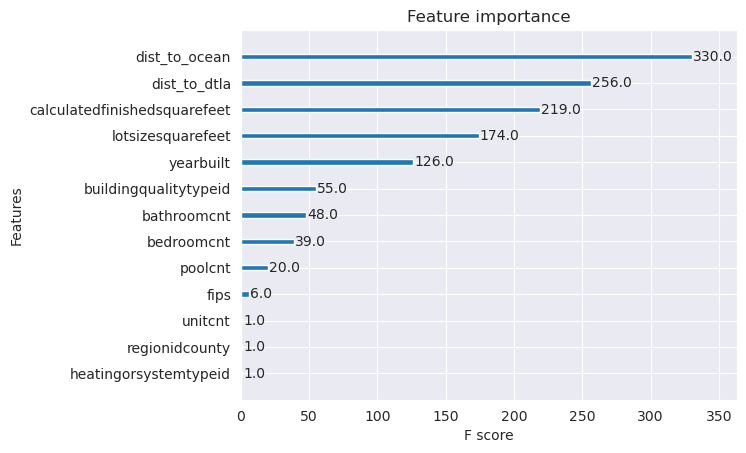

In [56]:
from xgboost import plot_importance
plot_importance(clf_town, max_num_features = 15)

In [43]:
d_train = lgb.Dataset(X_train_town, label=Y_train_town)
d_valid = lgb.Dataset(X_valid_town, label=Y_valid_town)

params = {}
params['learning_rate'] = 0.03
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'mae'
params['sub_feature'] = 0.5
params['num_leaves'] = 60
params['min_data'] = 500
params['min_hessian'] = 1

watchlist = [d_valid]
clf_town = lgb.train(params, d_train, 500, watchlist,early_stopping_rounds=10, verbose_eval=50)

print('Done!')

/accounts/grad/huz4/.local/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/accounts/grad/huz4/.local/lib/python3.11/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003583 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1129
[LightGBM] [Info] Number of data points in the train set: 39377, number of used features: 9
[LightGBM] [Info] Start training from score 490309.886406
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

In [44]:
# testing set error
get_eval_metrics([clf_town], X_test_town, Y_test_town)

Model: <lightgbm.basic.Booster object at 0x7f734fd3cf90>
MAE: 123085.95211696962, RMSE: 263361.2140531274


In [45]:
# testing log error
p_test = clf_town.predict(X_test_town)
p_test = replace_negative_with_one(p_test)
import math
logerror = np.log(p_test) - np.log(Y_test_town)
print('mean log error', np.mean(logerror))

mean log error 0.21932224797453626


## Gradient Boosting(AdaBoost)

In [62]:
ada = AdaBoostRegressor()
ada.fit(X_train_town, Y_train_town)
# training MAE and RMSE
get_eval_metrics([ada], X_train_town, Y_train_town)
# testing MAE and RMSE
get_eval_metrics([ada], X_test_town, Y_test_town)
#average log error
get_avg_log error(ada, X_test_con, Y_test_con)

Model: AdaBoostRegressor()
MAE: 122570.7273981219, RMSE: 145035.4344592369
Model: AdaBoostRegressor()
MAE: 123454.14709660552, RMSE: 145519.21521441775


## Linear Regression

In [63]:
#fitting regression model
regr = linear_model.LinearRegression()
regr.fit(X_train_town, Y_train_town)
print(regr.coef_)

[-5.82058647e-12 -5.80053820e+03 -1.51365476e+02  3.85861069e+03
  2.91038305e-11  2.37361595e+04 -5.12776212e+03  2.91038305e-11
  2.91038305e-11 -4.36557457e-11  7.97038889e+03  7.78975245e+03
 -1.84447419e+02  2.91038305e-11  0.00000000e+00 -2.91038305e-11
 -2.37330737e+02 -2.97101411e+04  0.00000000e+00 -1.92115887e+03
  4.46974719e+05  4.36713331e+05  2.50639733e+04  4.32663349e+03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -4.14338567e+03 -9.80503034e+02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  5.12388870e+03
  3.55530328e+01  4.80161095e+01 -8.35691423e+01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000

In [64]:
# training MAE and RMSE
get_eval_metrics([regr], X_train_town, Y_train_town)
# testing MAE and RMSE
get_eval_metrics([regr], X_test_town, Y_test_town)
#average log error
get_avg_log error(ada, X_test_con, Y_test_con)

Model: LinearRegression()
MAE: 39591.988832050825, RMSE: 67022.67771771182
Model: LinearRegression()
MAE: 38409.987217459166, RMSE: 61553.44256872763


# mobile_home

best_params ={'max_depth': 50,
              'n_estimators': 400,
            'max_features': 0.6,
            'min_samples_leaf': 16,
             'n_jobs':-1}
ran_forest_town = RandomForestRegressor(**best_params)
ran_forest_town.fit(X_train_town, Y_train_town)## Random forest

In [82]:
best_params ={'max_depth': 50,
              'n_estimators': 400,
            'max_features': 0.6,
            'min_samples_leaf': 16,
             'n_jobs':-1}
ran_forest_mob = RandomForestRegressor(**best_params)
ran_forest_mob.fit(X_train_mob, Y_train_mob)

RandomForestRegressor(max_depth=50, max_features=0.6, min_samples_leaf=16,
                      n_estimators=400, n_jobs=-1)

In [83]:
get_eval_metrics([ran_forest_mob], X_test_mob, Y_test_mob)

Model: RandomForestRegressor(max_depth=50, max_features=0.6, min_samples_leaf=16,
                      n_estimators=400, n_jobs=-1)
MAE: 19799.724760974746, RMSE: 75307.7989344847


In [84]:
get_avg_log_error(ran_forest_mob, X_test_mob, Y_test_mob)

Model: RandomForestRegressor(max_depth=50, max_features=0.6, min_samples_leaf=16,
                      n_estimators=400, n_jobs=-1)
log_error: -0.30515427686743535


## Gradient Boosting(XGBoost)

In [46]:
train_mob, valid_mob = train_test_split(train_mob, test_size=0.2)
#set validation set for early stopping

X_train_mob = train_mob.drop(['price'], axis =1)
Y_train_mob= train_mob['price']
X_valid_mob = valid_mob.drop(['price'], axis =1)
Y_valid_mob = valid_mob['price']

In [47]:
d_train_mob = xgb.DMatrix(X_train_mob, label=Y_train_mob)
d_valid_mob = xgb.DMatrix(X_valid_mob, label=Y_valid_mob)


print('Training ...')

params = {}
params['eta'] = 0.3
params['objective'] = 'reg:linear'
params['eval_metric'] = 'mae'
params['max_depth'] = 4
params['silent'] = 1

watchlist = [(d_train_mob, 'train'), (d_valid_mob, 'valid')]
clf_mob = xgb.train(params, d_train_mob, 10000, watchlist, early_stopping_rounds=10, verbose_eval=50)



d_test_mob = xgb.DMatrix(X_test_mob)


print('Predicting on test ...')

p_test_mob = clf_mob.predict(d_test_mob)

import math
logerror = np.log(p_test_mob) - np.log(Y_test_mob)
print('mean log error', np.mean(logerror))
print('Done!')

Training ...
[20:58:16] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[20:58:16] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	train-mae:31746.10788	valid-mae:30857.08837


/accounts/grad/huz4/.local/lib/python3.11/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[50]	train-mae:19725.23489	valid-mae:21424.68288
[88]	train-mae:18524.11869	valid-mae:21163.61273
Predicting on test ...
mean log error 0.32964289539790576
Done!


/tmp/ipykernel_883612/4240336220.py:27: RuntimeWarning: invalid value encountered in log
  logerror = np.log(p_test_mob) - np.log(Y_test_mob)


In [48]:
# testing set error
get_eval_metrics([clf_mob], d_test_mob, Y_test_mob)

Model: <xgboost.core.Booster object at 0x7f738c1a0050>
MAE: 20754.559561620015, RMSE: 72630.96827259648


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

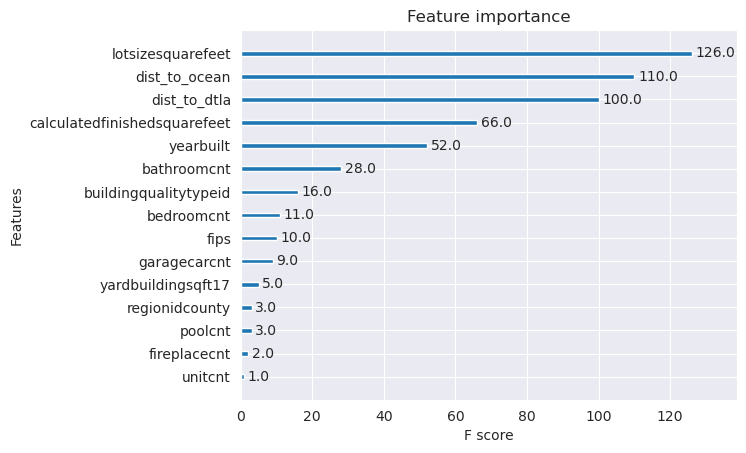

In [59]:
from xgboost import plot_importance
plot_importance(clf_mob, max_num_features = 15)

In [49]:
d_train = lgb.Dataset(X_train_mob, label=Y_train_mob)
d_valid = lgb.Dataset(X_valid_mob, label=Y_valid_mob)

params = {}
params['learning_rate'] = 0.03
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'mae'
params['sub_feature'] = 0.5
params['num_leaves'] = 60
params['min_data'] = 500
params['min_hessian'] = 1

watchlist = [d_valid]
clf_mob = lgb.train(params, d_train, 500, watchlist,early_stopping_rounds=10, verbose_eval=50)

print('Done!')

/accounts/grad/huz4/.local/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/accounts/grad/huz4/.local/lib/python3.11/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1110
[LightGBM] [Info] Number of data points in the train set: 18462, number of used features: 10
[LightGBM] [Info] Start training from score 43577.961813
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [50]:
# testing set error
get_eval_metrics([clf_mob], X_test_mob, Y_test_mob)

Model: <lightgbm.basic.Booster object at 0x7f73a8687a50>
MAE: 22569.505062385975, RMSE: 79034.24372217778


In [51]:
# testing log error

p_test = clf_mob.predict(X_test_mob)
p_test = replace_negative_with_one(p_test)
import math
logerror = np.log(p_test) - np.log(Y_test_mob)
print('mean log error', np.mean(logerror))

mean log error 0.3376563715626506


## Gradient Boosting(AdaBoost)

In [59]:
ada = AdaBoostRegressor()
ada.fit(X_train_mob, Y_train_mob)
# training MAE and RMSE
get_eval_metrics([ada], X_train_mob, Y_train_mob)
# testing MAE and RMSE
get_eval_metrics([ada], X_test_mob, Y_test_mob)
#average log error
get_avg_log error(ada, X_test_con, Y_test_con)

Model: AdaBoostRegressor()
MAE: 68140.43917512514, RMSE: 70891.87278956277
Model: AdaBoostRegressor()
MAE: 68588.90481014225, RMSE: 71203.7193121193


## Linear Regression

In [60]:
#fitting regression model
regr = linear_model.LinearRegression()
regr.fit(X_train_mob, Y_train_mob)
print(regr.coef_)

[-9.09226828e+03  9.50586513e+04 -6.19838660e+02 -5.39994276e+03
  5.32296126e+02  6.55393453e+04  1.84644790e+02 -1.02617848e+04
  3.57449579e+04  3.63797881e-11 -1.13653353e+04  2.02898029e+04
  2.77053088e+04  9.65201252e-11 -5.82076609e-11  1.45519152e-11
 -3.08586966e+01 -1.21057474e+05  9.34581714e+03 -4.67018495e+02
  3.21592345e+05  1.46570595e+05  8.21780796e+02 -1.78049442e+03
  2.27306707e+03  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -2.27306707e+03  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  2.27306707e+03  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.27306707e+03
 -1.29861226e+00 -1.70283621e+00  3.00144847e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000

In [ ]:
# training MAE and RMSE
get_eval_metrics([regr], X_train_town, Y_train_town)
# testing MAE and RMSE
get_eval_metrics([regr], X_test_town, Y_test_town)
#average log error
get_avg_log error(ada, X_test_con, Y_test_con)

## Full data

## Random forest

In [52]:
# do a 80,20 split on each data, set a seed
import random
random.seed(222)
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2)

In [53]:
X_train = train_df.drop(['price'], axis =1)
Y_train = train_df['price']
X_test = test_df.drop(['price'], axis =1)
Y_test = test_df['price']

In [55]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [79]:
# Fraction of original dataset given to any individual tree
max_samples = [0.1, 0.2]
# Number of features to consider at every split
max_features = ['auto', 0.4, 0.6, 0.8, 0.9]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(50, 100, num = 4)]
# max_depth.append(None)
# Minimum number of samples required at each leaf node
min_samples_leaf = [16, 32, 48]

# Create the tuning grid
param_grid = {
    'max_samples': max_samples,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_leaf': min_samples_leaf,
}

In [ ]:
###### Random Grid Sample Code #######
# Use the random grid to narrow down best hyperparameters

# First create the base model to tune
rf = RandomForestRegressor(max_samples=0.1)

# Random search of parameters, using 3 fold cross validation, 
# search across 20 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=20, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search model
rf_random.fit(X_train, Y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/linux/mambaforge-3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/linux/mambaforge-3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/linux/mambaforge-3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this pa

In [84]:
# Output the best estimator from grid search and it's hyperparameters 
rf_random.best_params_

{'min_samples_leaf': 16,
 'max_samples': 0.1,
 'max_features': 'auto',
 'max_depth': 50}

In [57]:
best_params ={'max_depth': 50,
              'n_estimators': 400,
            'max_features': 0.6,
            'min_samples_leaf': 16,
             'n_jobs':-1}
ran_forest = RandomForestRegressor(**best_params)
ran_forest.fit(X_train, Y_train)

RandomForestRegressor(max_depth=50, max_features=0.6, min_samples_leaf=16,
                      n_estimators=400, n_jobs=-1)

In [63]:
get_eval_metrics([ran_forest], X_test, Y_test)

Model: RandomForestRegressor(max_depth=50, max_features=0.6, min_samples_leaf=16,
                      n_estimators=400, n_jobs=-1)
MAE: 249307.94853857326, RMSE: 696254.7599032137


In [64]:
get_avg_log_error(ran_forest, X_test, Y_test)

Model: RandomForestRegressor(max_depth=50, max_features=0.6, min_samples_leaf=16,
                      n_estimators=400, n_jobs=-1)
log_error: -0.34595346573625996


## Gradient Boosting(XGBoost)

In [60]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer

In [61]:
# do a 80,20 split on each data, set a seed
import random
random.seed(222)
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2)

In [62]:
# split vaild set for early stopping

train_df, vaild_df = train_test_split(train_df, test_size=0.2)
X_train = train_df.drop(['price'], axis =1)
Y_train = train_df['price']
X_vaild = vaild_df.drop(['price'], axis =1)
Y_vaild = vaild_df['price']
X_test = test_df.drop(['price'], axis =1)
Y_test = test_df['price']

In [65]:
d_train = xgb.DMatrix(X_train, label=Y_train, enable_categorical= True)
d_valid = xgb.DMatrix(X_vaild, label=Y_vaild, enable_categorical= True)


print('Training ...')

params = {}
params['eta'] = 0.03
params['objective'] = 'reg:linear'
params['eval_metric'] = 'mae'
params['max_depth'] = 9
params['silent'] = 1

watchlist = [(d_train, 'train'), (d_valid, 'valid')]
clf = xgb.train(params, d_train, 10000, watchlist, early_stopping_rounds=10, verbose_eval=50)



d_test = xgb.DMatrix(X_test, enable_categorical= True)


print('Predicting on test ...')

p_test = clf.predict(d_test)

import math
logerror = np.log(p_test) - np.log(Y_test)
print('mean log error', np.mean(logerror))

Training ...
[17:07:59] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[17:07:59] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	train-mae:430162.71674	valid-mae:429917.50771
[50]	train-mae:193145.82355	valid-mae:195734.11064
[100]	train-mae:181345.19050	valid-mae:185396.51702
[150]	train-mae:179849.07725	valid-mae:184748.80081
[200]	train-mae:178346.37989	valid-mae:183796.98371
[250]	train-mae:176896.89767	valid-mae:182955.68122
[300]	train-mae:175491.34372	valid-mae:182234.46060
[350]	train-mae:174402.76652	valid-mae:181751.53221
[400]	train-mae:173573.87441	valid-mae:181412.67342
[450]	train-mae:172719.41284	valid-mae:181066.01723
[500]	train-mae:171972.58151	valid-mae:180845.07657
[550]	train-mae:171285.44004	valid-mae:180583.77526
[600]	train-mae:170587.76342	valid-mae:180378.64524
[650]	train-mae:170067.15878	valid-mae:180228.98429
[700]	train-mae:169597.44432	valid-mae:180107.10196
[750]	t

/tmp/ipykernel_419230/3824090160.py:27: RuntimeWarning: invalid value encountered in log
  logerror = np.log(p_test) - np.log(Y_test)


mean log error 0.17984133420777218


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

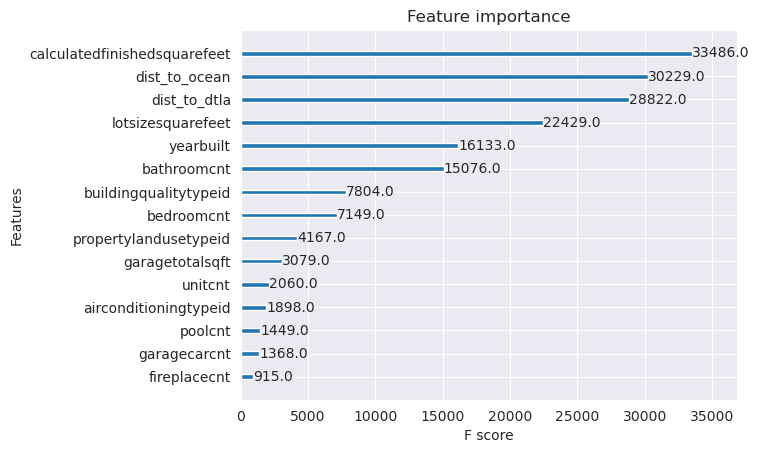

In [66]:
from xgboost import plot_importance
plot_importance(clf, max_num_features = 15)

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

xgbModel = xgb.XGBRegressor()

# define hyperparameters
params = {'max_depth': [3,4,5,6,7,8,9], 
          'colsample_bytree': [0.3, 0.5], 'subsample': [0.6, 0.8]}


gridSearchModel = GridSearchCV(estimator=xgbModel, 
                   param_grid=params, verbose=50, n_jobs=2, 
                   scoring='neg_mean_squared_error')
gridSearchModel.fit(X_train, Y_train)

print("Best parameters from Grid Search:", gridSearchModel.best_params_)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


In [22]:
 gridSearchModel.best_params_

{'colsample_bytree': 0.5, 'max_depth': 9, 'subsample': 0.8}

In [19]:
fit_params={'early_stopping_rounds': 10, 
            'eval_metric': 'mae',
            'verbose': False,
            'eval_set': [[X_test, Y_test]]}

get_eval_metrics([xgb_base], X_test, Y_test)
#get_cross_val_scores([xgb_base], X_prepared, y_train, cv=3, fit_params=fit_params)

Model: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.3, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=10000, n_jobs=0, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
MAE: 15754.003342989326, RMSE: 42784.2160122243


## Gradient Boosting(AdaBoost)

In [89]:
#purpose of the baseline model is to compare it to the performance of our model that utilizes adaBoost
#a tree with a depth of 3 had the lowest amount of error
crossvalidation=KFold(n_splits=10,shuffle=True,random_state=1)

for depth in range (1,10):
    tree_regressor=tree.DecisionTreeRegressor(max_depth=depth,random_state=1)
    if tree_regressor.fit(X_train, Y_train).tree_.max_depth<depth:
        break
    score=np.mean(cross_val_score(tree_regressor,X_train, Y_train,scoring='neg_mean_squared_error', cv=crossvalidation,n_jobs=1))
    print(depth, score)

1 -46344833059.82762
2 -25277656474.2639
3 -14718396893.084488
4 -9509117727.822412
5 -6491091189.639197
6 -5235825061.61236
7 -4462703574.433343
8 -3972578443.5325613
9 -3617737163.849251


In [128]:
ada = AdaBoostRegressor()
search_grid={'n_estimators':[100,500,1000],
             'learning_rate':[.001,0.01,.1],
             'random_state':[1]}

search = GridSearchCV(estimator = ada,
                    param_grid = search_grid,
                    scoring ='neg_mean_squared_error',
                    n_jobs = -1,
                    cv = crossvalidation)
search.fit(X_train, Y_train)
print(search.best_params_)
print(search.best_score_)

In [92]:
ada = AdaBoostRegressor()
ada.fit(X_train, Y_train)
# training MAE and RMSE
get_eval_metrics([ada], X_train, Y_train)
# testing MAE and RMSE
get_eval_metrics([ada], X_test, Y_test)
#average log error
get_avg_log error(ada, X_test_con, Y_test_con)

Model: AdaBoostRegressor()
MAE: 175854.97522283802, RMSE: 203864.9193521019
Model: AdaBoostRegressor()
MAE: 175826.61547409772, RMSE: 203935.5422394603


## Linear regression

In [119]:
#fitting regression model
regr = linear_model.LinearRegression()
regr.fit(X_train, Y_train)
print(regr.coef_)

[-6.56272808e+11  1.00751248e+03  2.68272766e+03 -3.19451050e+03
  4.08433502e+11  7.55978748e+03  5.51273284e+11 -4.89239258e+03
  2.43095020e+03 -1.38912742e+04  3.24438859e+11  1.01560955e+04
 -1.90344568e+03 -4.94258398e+03 -1.65736409e+09  6.41091129e+09
  9.51869690e+10  2.65769340e+04 -9.14770752e+02 -5.52596191e+02
  4.93124990e+05  4.48810549e+05 -1.01782025e+03  1.73415332e+03
 -4.08312728e+12  2.47960081e+12  3.13587362e+12  3.79214639e+12
 -2.77058166e+12 -1.45803603e+12  1.16705518e+12  6.11508726e+12
  3.19513753e+12  2.87069866e+12  2.54625983e+12  2.22182092e+12
  1.89738213e+12  5.99626639e+11  5.79064842e+12 -4.92509575e+10
 -3.73689949e+11 -1.34700651e+12  4.49289296e+12  4.16845413e+12
 -3.73844915e+13  4.29336697e+13 -8.28442015e+12 -3.74608239e+12
 -3.75249331e+12 -3.75890423e+12 -3.83583515e+12 -3.84224606e+12
 -3.85506813e+12 -3.86147883e+12 -3.86788974e+12 -3.87430064e+12
 -3.88071155e+12 -3.89353335e+12 -3.93199887e+12 -3.95764261e+12
 -2.36773642e+12 -2.47031

In [31]:
# training MAE and RMSE
get_eval_metrics([regr], X_train, Y_train)
# testing MAE and RMSE
get_eval_metrics([regr], X_test, Y_test)
#average log error
get_avg_log error(ada, X_test_con, Y_test_con)

Model: LinearRegression()
MAE: 31168.51443039537, RMSE: 61800.389676774495
Model: LinearRegression()
MAE: 53933803.32921106, RMSE: 35666460711.091
